In [1]:
import os
import pandas as pd
from tqdm import tqdm
import cv2
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS
from astropy import units as u
from matplotlib import pyplot as plt

In [2]:
def fits2png(img_fits):
    old_img = img_fits.data
    img_shape = old_img.shape[0]
    old_vmax = np.max(old_img)
    old_vmin = np.min(old_img)

    new_img = np.zeros((img_shape, img_shape))
    new_vmax = 255
    new_vmin = 0

    new_img = np.round( ( (old_img - old_vmin) / (old_vmax - old_vmin) ) * 255)
    name='./temp/crab_sky.png'
    cv2.imwrite(name, new_img)
    return np.int32(new_img)

In [3]:
def threshSegmEstimate(img, eps=1):
    print('max:',np.max(img), 'eps:', eps, 'max-eps', np.max(img)-eps)
    print('mean:',np.mean(img), 'median:', np.median(img), 'std', np.std(img))
    return np.max(img)-eps

def threshSegmEstimate1(img, c=10.5):
    mu = np.mean(img)
    T = np.ceil(np.max(img) - mu)//2
    return T+mu

def find_percentile_value(hist, percentile):
    s = 0
    idx = 0
    total_pixel = np.sum(hist)
    while(s < total_pixel*percentile/100):
        s += hist[idx]
        idx += 1
    return idx

def threshSegmEstimate2(img, p=90, c=10):
    hist, bins = np.histogram(img.astype(np.uint8).flatten(),256,[0,256])
    v = find_percentile_value(hist, p)
    T = v + 10
    return T

In [4]:
def findCentroid(img):
    contours = cv2.findContours(img,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)[1]
    centroids = []
    for c in contours:
        M = cv2.moments(c, binaryImage=True)
        # calculate x,y coordinate of center
        if M['m00'] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            centroids.append(np.array([cX, cY]))
    return centroids

In [5]:
def convert_pix2wcs(centroids, hdul):
    sources_predicted = []
    for c in centroids:
        # get map
        wcs = WCS(hdul[0].header)
        wcs_coords = wcs.pixel_to_world(c[0], c[1])
        sources_predicted.append(np.array([np.float32(wcs_coords.ra), 
                                           np.float32(wcs_coords.dec)]))
    return sources_predicted

In [6]:
def plot(img, title, figsize=(8,8)):
    plt.figure(figsize=figsize)
    plt.imshow(img, cmap='gray', vmin=0, vmax=255)
    plt.colorbar()
    plt.title(title)
    plt.show()

In [7]:
# k_md_size=0
# sigma=4
# eps_seg=10
# alpha_power=0.4
# # alpha_power=1.4
# k_gs_size=17
# k_ers_size=0
# k_dil_size=0
# T_source_present=77

In [8]:
def linear_stretching(img, max_value, min_value):
    img[img<min_value] = min_value
    img[img>max_value] = max_value
    linear_stretched_img = 255//(max_value-min_value)*(img-min_value)
    return linear_stretched_img

def power(img, r):
    exp_img = ((img/255)**r) *255
    return np.ceil(exp_img)

def find_percentile_value(hist, percentile):
    s = 0
    idx = 0
    total_pixel = np.sum(hist)
    while(s < total_pixel*percentile/100):
        s += hist[idx]
        idx += 1
    return idx

In [9]:
k_md_size=0
sigma=6
p=98
k_gs_size=15
eps_seg=16
# alpha_power= 0.2
beta_power = 0
LCS = False
alpha_power= 1.1
k_ers_size=0
ers_niterations=0
k_dil_size=0
T_source_present=77

In [10]:
# one source low intensity
skymap = './data/dataset/skymaps/crab_sky12.fits'

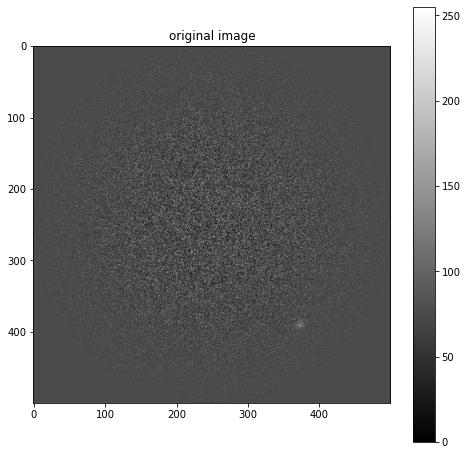

75.357132


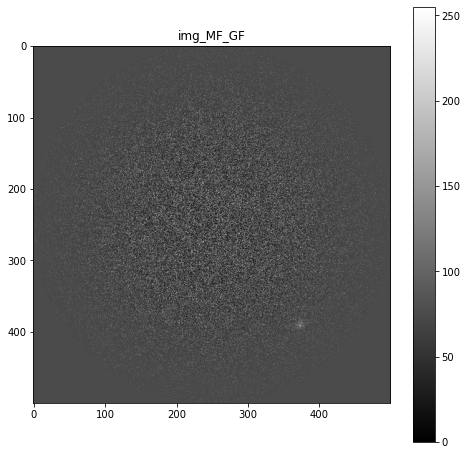

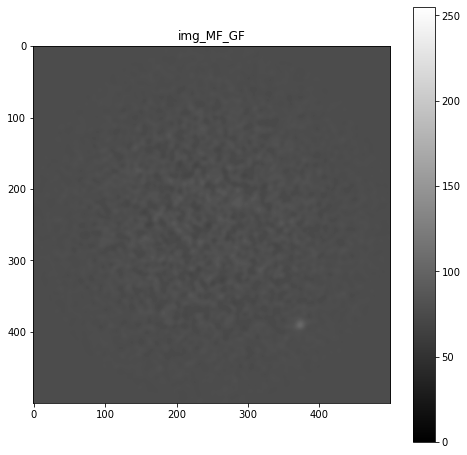

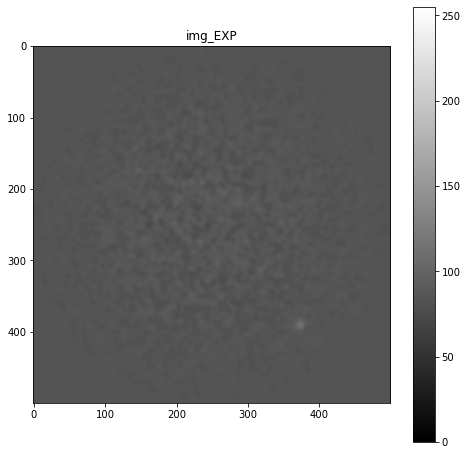

max: 114 eps: 16 max-eps 98
mean: 84.32728 median: 84.0 std 2.0933379568526433
98 99.32728 101


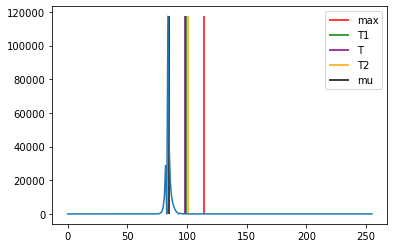

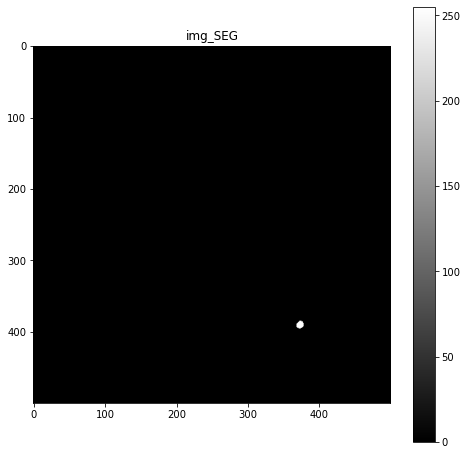

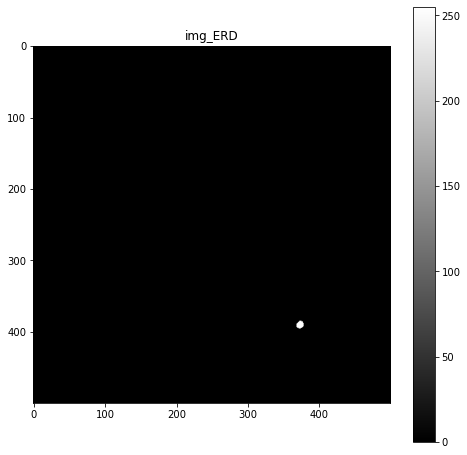

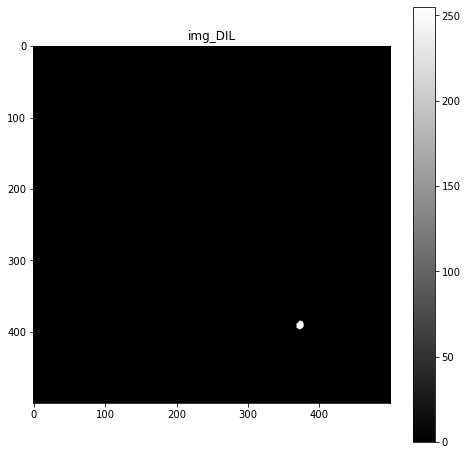

[array([80.92619 , 25.302341], dtype=float32)]


Set MJD-END to 51544.000000 from DATE-END'. [astropy.wcs.wcs]


In [11]:
# open the skymap
hdul = fits.open(skymap)
# and convert it from .fits to .png
img = fits2png(hdul[0].data)
img = cv2.imread('./temp/crab_sky.png', cv2.IMREAD_GRAYSCALE)
plot(img, 'original image')

mu = np.mean(img)
print(mu)
if mu < T_source_present:
    
    # Application of smoothing filters
    if k_md_size > 0:
        img_MF_GF = cv2.medianBlur(img, k_md_size)
    else:
        img_MF_GF = img
    plot(img_MF_GF, 'img_MF_GF')
    if k_gs_size==0:
        k_gs_size = int(np.ceil((3*sigma))*2+1)
    img_MF_GF = cv2.GaussianBlur(img_MF_GF, (k_gs_size,k_gs_size) , sigma)

    plot(img_MF_GF, 'img_MF_GF')
    # Power scale intensity
    if LCS == True:
#         hist, bins = np.histogram(img_MF_GF.astype(np.uint8).flatten(),256,[0,256])
#         max_value = find_percentile_value(hist, 99.8)
#         min_value = find_percentile_value(hist, 0.2)
#         print("Max 95%: ", max_value, " Min 5%: ", min_value)
        img_EXP = linear_stretching(img_MF_GF, np.min(img_MF_GF), np.min(img_MF_GF))
    else:
        if alpha_power == -1:
            alpha_power= np.log(np.mean(img_MF_GF))/np.log(128)
            print(alpha_power)
        img_EXP = cv2.convertScaleAbs(img_MF_GF, alpha=alpha_power)
#             img_EXP = power(img_MF_GF, alpha_power)
    plot(img_EXP, 'img_EXP')

    # Estimate threshold segmentation
    T = threshSegmEstimate(img_EXP, eps=eps_seg)
    T1 = threshSegmEstimate1(img_EXP, c=6)
    T2 = threshSegmEstimate2(img_EXP, p=p)
    print(T, T1, T2)
    
    hist, bins = np.histogram(img_EXP.astype(np.uint8).flatten(),256,[0,256])
    plt.vlines(np.max(img_EXP), 0, np.max(hist), colors='red', label='max')
    plt.vlines(T1, 0, np.max(hist), colors='green', label='T1')
    plt.vlines(T, 0, np.max(hist), colors='purple', label='T')
    plt.vlines(T2, 0, np.max(hist), colors='orange', label='T2')
    plt.vlines(np.ceil(np.mean(img_EXP)), 0, np.max(hist), colors='black', label='mu')
    plt.legend()
    plt.plot(hist)
    # Segmentation
    ret2, img_SEG = cv2.threshold(img_EXP,T2,255,cv2.THRESH_BINARY)
#     ret2, img_SEG = cv2.threshold(img_EXP,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
#     img_SEG = cv2.adaptiveThreshold(img_EXP,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,49,10)
#     ret2, img_SEG = cv2.threshold(img_EXP,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    plot(img_SEG, 'img_SEG')
    # Erosion
    if not k_ers_size == 0:
        img_ERD = cv2.erode(img_SEG, (k_ers_size,k_ers_size), iterations=ers_niterations)
    else:
        img_ERD = img_SEG
    plot(img_ERD, 'img_ERD')
    # Dilation
    if not k_dil_size == 0:
        img_DIL = cv2.dilate(img_ERD, (k_dil_size,k_dil_size), iterations=1)
    else:
        img_DIL = img_ERD
    plot(img_DIL, 'img_DIL')
    # Find the centroid of the image
    centroids = findCentroid(img_DIL)
    # Convertion of pixel coordinates to wcs coordinates
    centroids = convert_pix2wcs(centroids, hdul)
print(centroids)

In [12]:
# trhee sources normal intensity
skymap = './data/dataset/skymaps/crab_sky33.fits'

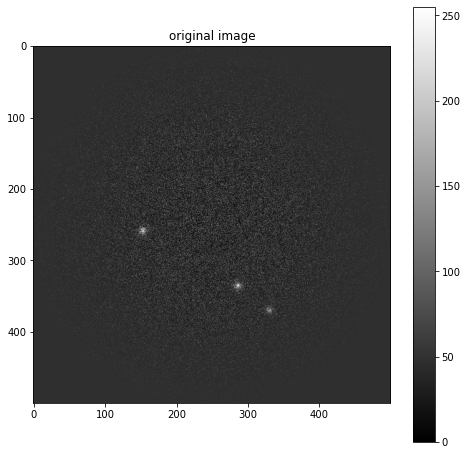

47.543584


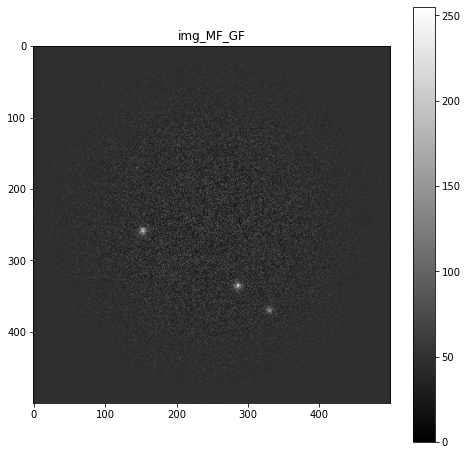

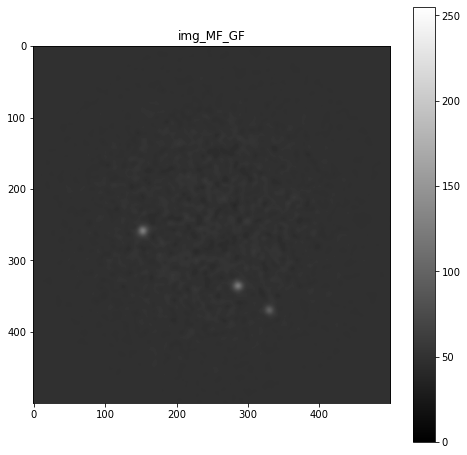

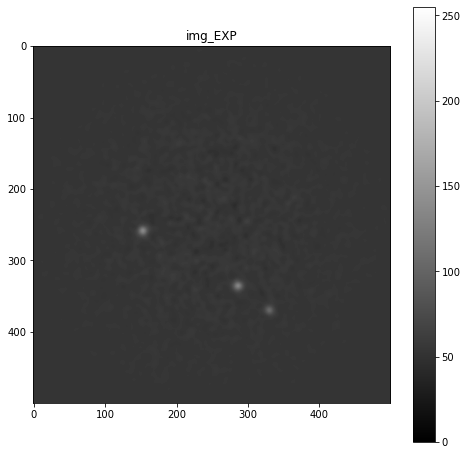

max: 135 eps: 16 max-eps 119
mean: 53.35686 median: 53.0 std 2.3487083557564143
119 94.35686 68


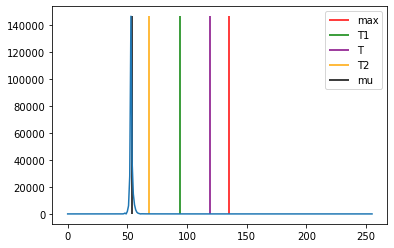

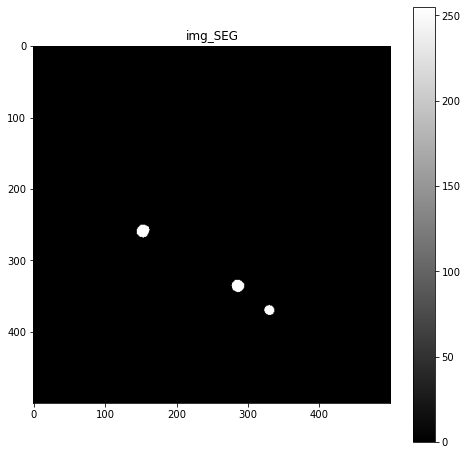

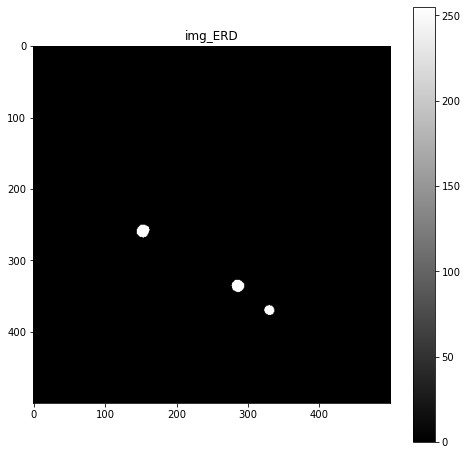

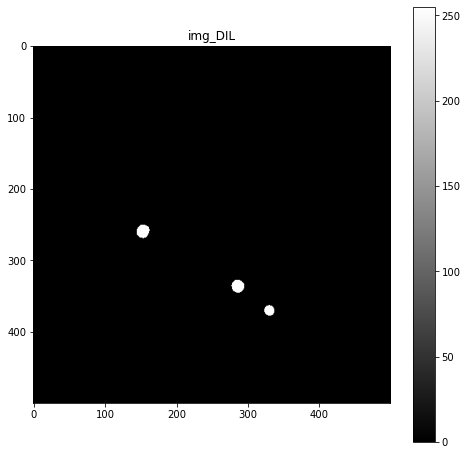

[array([81.88144 , 24.915194], dtype=float32), array([82.85478 , 24.242653], dtype=float32), array([85.725075, 22.69101 ], dtype=float32)]


Set MJD-END to 51544.000000 from DATE-END'. [astropy.wcs.wcs]


In [13]:
# open the skymap
hdul = fits.open(skymap)
# and convert it from .fits to .png
img = fits2png(hdul[0].data)
img = cv2.imread('./temp/crab_sky.png', cv2.IMREAD_GRAYSCALE)
plot(img, 'original image')

mu = np.mean(img)
print(mu)
if mu < T_source_present:
    
    # Application of smoothing filters
    if k_md_size > 0:
        img_MF_GF = cv2.medianBlur(img, k_md_size)
    else:
        img_MF_GF = img
    plot(img_MF_GF, 'img_MF_GF')
    if k_gs_size==0:
        k_gs_size = int(np.ceil((3*sigma))*2+1)
    img_MF_GF = cv2.GaussianBlur(img_MF_GF, (k_gs_size,k_gs_size) , sigma)

    plot(img_MF_GF, 'img_MF_GF')
    # Power scale intensity
    if LCS == True:
#         hist, bins = np.histogram(img_MF_GF.astype(np.uint8).flatten(),256,[0,256])
#         max_value = find_percentile_value(hist, 99.8)
#         min_value = find_percentile_value(hist, 0.2)
#         print("Max 95%: ", max_value, " Min 5%: ", min_value)
        img_EXP = linear_stretching(img_MF_GF, np.min(img_MF_GF), np.min(img_MF_GF))
    else:
        if alpha_power == -1:
            alpha_power= np.log(np.mean(img_MF_GF))/np.log(128)
            print(alpha_power)
        img_EXP = cv2.convertScaleAbs(img_MF_GF, alpha=alpha_power)
#             img_EXP = power(img_MF_GF, alpha_power)
    plot(img_EXP, 'img_EXP')

    # Estimate threshold segmentation
    T = threshSegmEstimate(img_EXP, eps=eps_seg)
    T1 = threshSegmEstimate1(img_EXP, c=6)
    T2 = threshSegmEstimate2(img_EXP, p=p)
    print(T, T1, T2)
    
    hist, bins = np.histogram(img_EXP.astype(np.uint8).flatten(),256,[0,256])
    plt.vlines(np.max(img_EXP), 0, np.max(hist), colors='red', label='max')
    plt.vlines(T1, 0, np.max(hist), colors='green', label='T1')
    plt.vlines(T, 0, np.max(hist), colors='purple', label='T')
    plt.vlines(T2, 0, np.max(hist), colors='orange', label='T2')
    plt.vlines(np.ceil(np.mean(img_EXP)), 0, np.max(hist), colors='black', label='mu')
    plt.legend()
    plt.plot(hist)
    # Segmentation
    ret2, img_SEG = cv2.threshold(img_EXP,T2,255,cv2.THRESH_BINARY)
#     ret2, img_SEG = cv2.threshold(img_EXP,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
#     img_SEG = cv2.adaptiveThreshold(img_EXP,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,49,10)
#     ret2, img_SEG = cv2.threshold(img_EXP,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    plot(img_SEG, 'img_SEG')
    # Erosion
    if not k_ers_size == 0:
        img_ERD = cv2.erode(img_SEG, (k_ers_size,k_ers_size), iterations=ers_niterations)
    else:
        img_ERD = img_SEG
    plot(img_ERD, 'img_ERD')
    # Dilation
    if not k_dil_size == 0:
        img_DIL = cv2.dilate(img_ERD, (k_dil_size,k_dil_size), iterations=1)
    else:
        img_DIL = img_ERD
    plot(img_DIL, 'img_DIL')
    # Find the centroid of the image
    centroids = findCentroid(img_DIL)
    # Convertion of pixel coordinates to wcs coordinates
    centroids = convert_pix2wcs(centroids, hdul)
print(centroids)

In [14]:
# trhee which two of them overlaps
skymap = './data/dataset/skymaps/crab_sky196.fits'

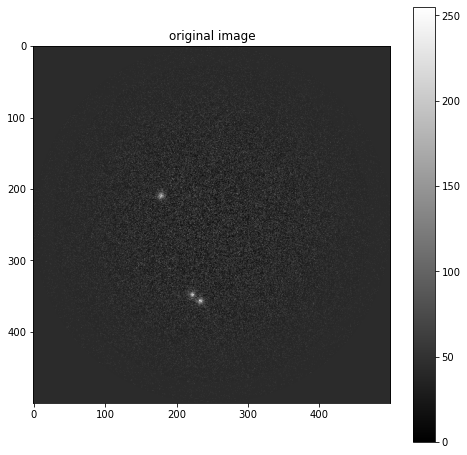

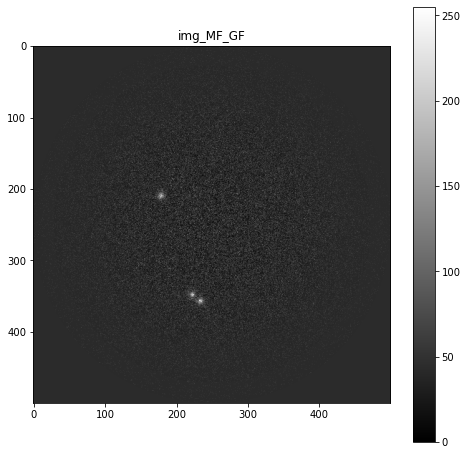

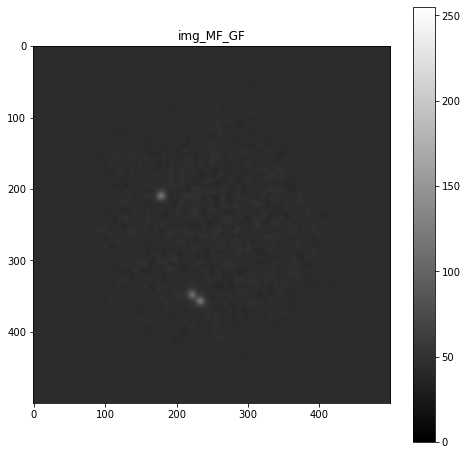

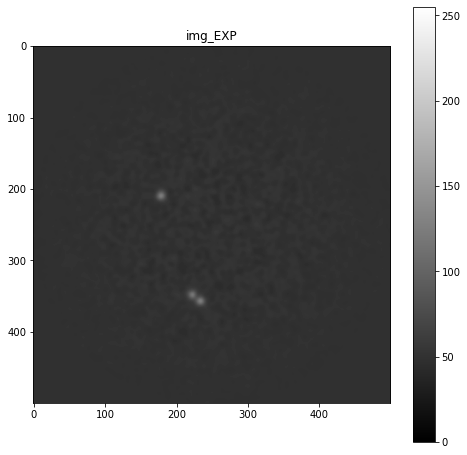

max: 125 eps: 16 max-eps 109
mean: 48.445748 median: 48.0 std 2.480511382859591
109 86.44574800000001 63


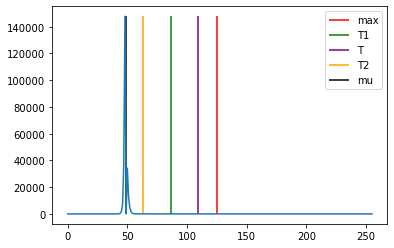

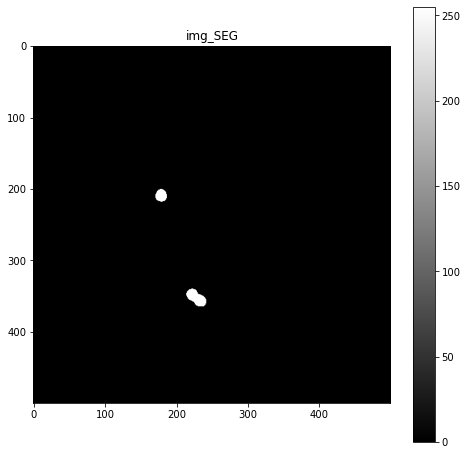

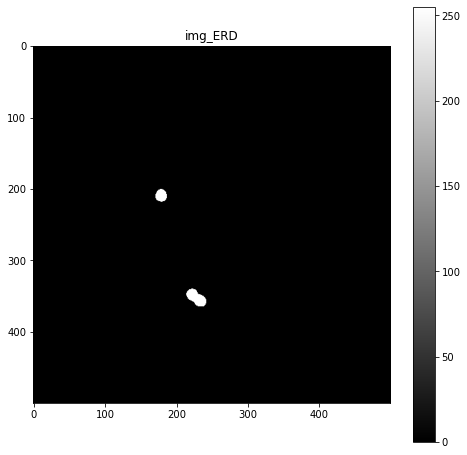

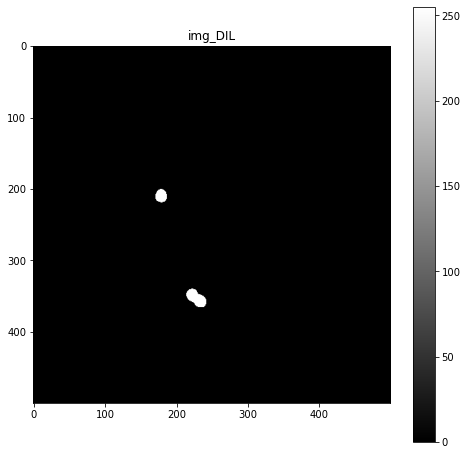

[array([84.12763 , 24.583755], dtype=float32), array([85.17223 , 21.717146], dtype=float32)]


Set MJD-END to 51544.000000 from DATE-END'. [astropy.wcs.wcs]


In [15]:
# open the skymap
hdul = fits.open(skymap)
# and convert it from .fits to .png
img = fits2png(hdul[0].data)
img = cv2.imread('./temp/crab_sky.png', cv2.IMREAD_GRAYSCALE)
plot(img, 'original image')

# Application of smoothing filters
if k_md_size > 0:
    img_MF_GF = cv2.medianBlur(img, k_md_size)
else:
    img_MF_GF = img
plot(img_MF_GF, 'img_MF_GF')
if k_gs_size==0:
    k_gs_size = int(np.ceil((3*sigma))*2+1)
img_MF_GF = cv2.GaussianBlur(img_MF_GF, (k_gs_size,k_gs_size) , sigma)

plot(img_MF_GF, 'img_MF_GF')
# Power scale intensity
#     if LCS == True:
#         hist, bins = np.histogram(img_MF_GF.astype(np.uint8).flatten(),256,[0,256])
#         max_value = find_percentile_value(hist, 99.8)
#         min_value = find_percentile_value(hist, 0.2)
#         print("Max 95%: ", max_value, " Min 5%: ", min_value)
#         img_EXP = linear_stretching(img_MF_GF, np.min(img_MF_GF), np.min(img_MF_GF))
#     else:
if alpha_power == -1:
    alpha_power= np.log(np.mean(img_MF_GF))/np.log(128)
    print(alpha_power)
img_EXP = cv2.convertScaleAbs(img_MF_GF, alpha=alpha_power)
#             img_EXP = power(img_MF_GF, alpha_power)
plot(img_EXP, 'img_EXP')

# Estimate threshold segmentation
T = threshSegmEstimate(img_EXP, eps=eps_seg)
T1 = threshSegmEstimate1(img_EXP, c=6)
T2 = threshSegmEstimate2(img_EXP, p=p)
print(T, T1, T2)

hist, bins = np.histogram(img_EXP.astype(np.uint8).flatten(),256,[0,256])
plt.vlines(np.max(img_EXP), 0, np.max(hist), colors='red', label='max')
plt.vlines(T1, 0, np.max(hist), colors='green', label='T1')
plt.vlines(T, 0, np.max(hist), colors='purple', label='T')
plt.vlines(T2, 0, np.max(hist), colors='orange', label='T2')
plt.vlines(np.ceil(np.mean(img_EXP)), 0, np.max(hist), colors='black', label='mu')
plt.legend()
plt.plot(hist)
# Segmentation
ret2, img_SEG = cv2.threshold(img_EXP,T2,255,cv2.THRESH_BINARY)
#     ret2, img_SEG = cv2.threshold(img_EXP,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
#     img_SEG = cv2.adaptiveThreshold(img_EXP,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,49,10)
#     ret2, img_SEG = cv2.threshold(img_EXP,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
plot(img_SEG, 'img_SEG')
# Erosion
if not k_ers_size == 0:
    img_ERD = cv2.erode(img_SEG, (k_ers_size,k_ers_size), iterations=ers_niterations)
else:
    img_ERD = img_SEG
plot(img_ERD, 'img_ERD')
# Dilation
if not k_dil_size == 0:
    img_DIL = cv2.dilate(img_ERD, (k_dil_size,k_dil_size), iterations=1)
else:
    img_DIL = img_ERD
plot(img_DIL, 'img_DIL')
# Find the centroid of the image
centroids = findCentroid(img_DIL)
# Convertion of pixel coordinates to wcs coordinates
centroids = convert_pix2wcs(centroids, hdul)
print(centroids)